In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [4]:
cd python_for_microscopists

/content/gdrive/MyDrive


In [5]:
!pip install -U pre segmentation

     |████████████████████████████████| 450kB 4.3MB/s 
  Created wheel for pre: filename=pre-1.3.0-cp37-none-any.whl size=1369 sha256=bb29597160863274b5fd759230573c113318a64164c7951998cdc31faf15a1a9
  Stored in directory: /root/.cache/pip/wheels/10/98/89/616ea43c08b5c5067722d35d45d72524b924607172e57d91c6
Successfully built pre


In [6]:
!pip install efficientnet

     |████████████████████████████████| 51kB 3.1MB/s 


In [7]:
!pip install image-classifiers

In [8]:
import tensorflow as tf

In [9]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [10]:
#  

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

# from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [11]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [12]:
#Resizing images, if needed
SIZE_X = 1024
SIZE_Y = 1024
n_classes=8 #Number of classes for segmentation

In [13]:
#Capture training image info as a list
# train_images = []

# for directory_path in glob.glob("images/"):
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         img = cv2.imread(img_path, 1)       
#         img = cv2.resize(img, (SIZE_Y, SIZE_X))
#         train_images.append(img)
       
# #Convert list to array for machine learning processing        
# train_images = np.array(train_images)

In [14]:
image_names = glob.glob("/content/gdrive/My Drive/images/*.jpg")
image_names.sort()
#image_names_subset = image_names[0:num_images]
train_images=[]
for image in image_names:
  img=cv2.imread(image, 1)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  train_images.append(img)

train_images = np.array(train_images)

In [15]:
# #Capture mask/label info as a list
# train_masks = [] 
# for directory_path in glob.glob("masks/"):
#     for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
#         mask = cv2.imread(mask_path, 0)       
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
#         train_masks.append(mask)
        
# #Convert list to array for machine learning processing          
# train_masks = np.array(train_masks)

In [16]:
mask_names = glob.glob("/content/gdrive/My Drive/masks/*.png")
mask_names.sort()
#mask_names_subset = mask_names[0:num_images]
train_masks = [] 
for maskpath in mask_names:
  mask = cv2.imread(maskpath, 0)       
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
  train_masks.append(mask)

train_masks = np.array(train_masks)

In [17]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#################################################
# train_images = np.expand_dims(train_images, axis=3)
# train_images = tf.keras.utils.normalize(train_images, axis=1)

# train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6, 7])

In [18]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [19]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3 4 5 6 7]


In [20]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


In [21]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [22]:
#Reused parameters in all models

n_classes=8
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.125, 0.125, 0.125, 0.125,0.125, 0.125, 0.125, 0.125])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [23]:
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [24]:
###Model 1
BACKBONE1 = 'resnext50'
# BACKBONE1 ='vgg16'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# checkpoint = ModelCheckpoint("resnet_unet_model.h5", monitor='val_iou_score',  save_best_only=True, mode='auto', save_freq='epoch')


# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)


94429184/94428600 [==============================] - 5s 0us/step


In [25]:
print(model1.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [26]:
#load model for retraining 
# model1 = load_model('unet_res34_backbone_200epochs.hdf5',custom_objects={'dice_loss + (1 * focal_loss)': total_loss}, compile=True)

In [44]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=2, 
          epochs=100,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

Epoch 1/100
18/18 [==============================] - 14s 794ms/step - loss: 0.8881 - iou_score: 0.9912 - f1-score: 0.9956 - val_loss: 0.8933 - val_iou_score: 0.9223 - val_f1-score: 0.9574
Epoch 2/100
18/18 [==============================] - 14s 783ms/step - loss: 0.8889 - iou_score: 0.9915 - f1-score: 0.9957 - val_loss: 0.8934 - val_iou_score: 0.9218 - val_f1-score: 0.9571
Epoch 3/100
18/18 [==============================] - 14s 790ms/step - loss: 0.8890 - iou_score: 0.9913 - f1-score: 0.9956 - val_loss: 0.8935 - val_iou_score: 0.9219 - val_f1-score: 0.9572
Epoch 4/100
18/18 [==============================] - 14s 791ms/step - loss: 0.8907 - iou_score: 0.9912 - f1-score: 0.9956 - val_loss: 0.8933 - val_iou_score: 0.9230 - val_f1-score: 0.9579
Epoch 5/100
18/18 [==============================] - 14s 783ms/step - loss: 0.8916 - iou_score: 0.9907 - f1-score: 0.9953 - val_loss: 0.8933 - val_iou_score: 0.9239 - val_f1-score: 0.9583
Epoch 6/100
18/18 [==============================] - 14s 790

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [43]:
# model1.save('unet_resnext34_backbone_500epochs_newDS_1024.hdf5') #first model with new dataset using resnext backbone

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# model1 = load_model('unet_resnet34_backbone_500epochs_512_newDS_1024.hdf5', compile=False)

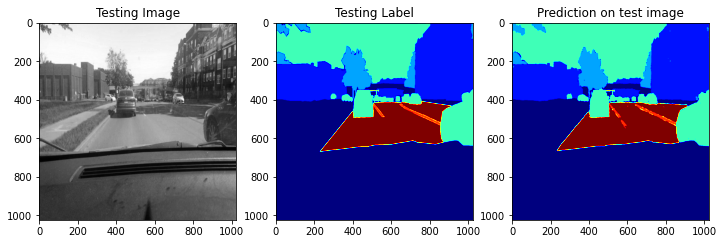

In [42]:
# Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()


In [ ]:
###Model 2

BACKBONE2 = 'resnext50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


In [ ]:
history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=4, 
          epochs=500,
          verbose=1,
          validation_data=(X_test2, y_test_cat))

In [ ]:
model2.save('unet_resnext50_backbone_500epochs_newDS.hdf5')

In [ ]:
y_pred2=model2.predict(X_test2)
y_pred2_argmax=np.argmax(y_pred2, axis=3)

In [ ]:
n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
# model2.save('unet_resnext50_backbone_500epochs.hdf5')

In [ ]:
model2 = load_model('unet_resnext50_backbone_500epochs.hdf5', compile=False)

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input2(test_img_input)

test_pred1 = model2.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

In [ ]:
while True:
  pass

In [ ]:
###Model 1
#BACKBONE1 = 'resnet34'
BACKBONE3 ='inceptionv3'

preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics=metrics)

In [ ]:
history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=16, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))

In [ ]:
# model3.save('unet_inceptionv3_backbone_200epochs.hdf5')

In [ ]:
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[0]
ground_truth=y_test[0]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()


In [ ]:
while True:
  pass

In [ ]:
pwd